In [4]:
# the idea of patch merging

In [5]:
import numpy as np

In [6]:
#settings
patch_size =  5
patch_edge =  1  # overlap parts into/out of space

In [7]:
#computed
patch_step = patch_size - 2*patch_edge
patch_off = int((patch_size - patch_step)/2)

In [8]:
print patch_step

3


In [7]:
# compute patch interpolation mask...
# linear mask so outer edge should be almost zero.. accounts for 1-4 overlaping pixels
# internal pixels should still range between [0,1.0] after summnation
edge_overlap = 2*patch_edge

row_left  = np.ones(patch_step + patch_edge)
row_mid   = np.ones(patch_size)
row_right = np.ones(patch_edge + patch_step)

# oddies here.. edge doesnt include 0 and 1 (that would be waste computation)
m1 = 1.0/float(edge_overlap+1)
x1 = (np.arange(1,edge_overlap+1))*m1

row_mid  [:edge_overlap] = x1
row_right[:edge_overlap] = x1

x1 = np.fliplr([x1])[0]

row_mid  [(row_mid .shape[0] - edge_overlap):] = x1
row_left [(row_left.shape[0] - edge_overlap):] = x1

rows = [row_left, row_mid, row_right]

In [8]:
# test 
print row_mid
merge = np.zeros(3*patch_step)
merge[                           :(                           row_left .shape[0])] += row_left
merge[(1*patch_step - patch_edge):(1*patch_step - patch_edge +row_mid  .shape[0])] += row_mid
merge[(2*patch_step - patch_edge):] += row_right

print merge
print "Pass:", np.sum(merge) == (3*patch_step)

[ 0.33333333  0.66666667  1.          0.66666667  0.33333333]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
Pass: True


In [9]:
# ok lets make it 2d...
masks = []
for row in rows:
    mask_row = []
    for col in rows:
        mask = np.matmul(col.reshape((col.shape[0],1)), row.reshape((1,row.shape[0])))
        mask_row.append(mask)
    masks.append(mask_row)

In [19]:
def mask_idx(idx,limit):
    if idx == 0:
        return 0
    elif idx == limit-1:
        return 2
    else:
        return 1 

merge = np.zeros(((3*patch_step),(3*patch_step)))
steps = 3
for y in range(steps):
    mask_y = mask_idx(y,steps)
    for x in range(steps):
        mask_x = mask_idx(x,steps)            
        mask = masks[mask_y][mask_x]

        y_min = patch_step*y - patch_edge
        y_max = y_min + patch_size
        y_min = max(0,y_min)
        y_max = min(merge.shape[1],y_max)
        
        x_min = patch_step*x - patch_edge
        x_max = x_min + patch_size
        x_min = max(0,x_min)
        x_max = min(merge.shape[0],x_max)

        merge[x_min:x_max,y_min:y_max] += mask

print merge
print "Pass:", np.sum(merge) == (3*patch_step)*(3*patch_step)

[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]]
Pass: True


In [9]:
import time
def timer_sync():
    tnow = time.time()
    return tnow
    
def timer_check(idx,tots,prior):
    tnow = time.time()
    tots[idx] += tnow - prior
    return tnow

def timer_finish(tots):
    print "timing:", tots

In [17]:
class PatchInterpolationSequancer:
    # this class is about extracting a sequance of patches from a image, processoring them and merging the results
    # back into the original while interpolating the edges of the patches

    # this allows you to overlap model predictions on patches from an image and blend them together at the edges
    
    # it uses interpolation masks to merge the transformed patches into the final image
    def generate_interploation_vectors(self):    
        # compute patch interpolation mask...
        # linear mask so outer edge should be almost zero.. accounts for 1-4 overlaping pixels
        # internal pixels should still range between [0,1.0] after summnation
        edge_overlap = 2*self.patch_edge

        row_left  = np.ones(self.patch_step + self.patch_edge)
        row_mid   = np.ones(self.patch_size)
        row_right = np.ones(self.patch_edge + self.patch_step)

        # oddies here.. edge doesnt include 0 and 1 (that would be waste computation)
        m1 = 1.0/float(edge_overlap+1)
        x1 = (np.arange(1,edge_overlap+1))*m1

        row_mid  [:edge_overlap] = x1
        row_right[:edge_overlap] = x1

        x1 = np.fliplr([x1])[0]

        row_mid  [(row_mid .shape[0] - edge_overlap):] = x1
        row_left [(row_left.shape[0] - edge_overlap):] = x1
        
        return [row_left, row_mid, row_right]
    
    def generate_masks(self):
        rows = self.generate_interploation_vectors()

        masks = []
        for row in rows:
            mask_row = []
            for col in rows:
                mask = np.matmul(col.reshape((col.shape[0],1)), row.reshape((1,row.shape[0])))
                mask_row.append(mask)
            masks.append(mask_row)
    
        return masks

    def mask_idx(self,idx,limit):
        if idx == 0:
            # left/top edge
            return 0, self.patch_edge, self.patch_size
        elif idx == limit-1:
            # right/bottom
            return 2, 0, self.patch_size - self.patch_edge
        else:
            return 1, 0, self.patch_size 
        
    def access_ranges(self, x, img_size):
        img_min = self.patch_step*x - self.patch_edge
        img_max = img_min + self.patch_size

        patch_min = -min(0,img_min)                        # the part of the patch outside the left edge
        patch_max = self.patch_size - max(0,img_max - img_size) # patch size - the part of the patch out side the right edge

        img_min = max(0,img_min)
        img_max = min(img_size,img_max)
        
        return patch_min, patch_max, img_min, img_max


    def __init__(self,
                patch_size,  
                patch_edge): 
        self.patch_size  = patch_size  # size (square) of the patch to extract
        self.patch_edge  = patch_edge  # overlap in the edge of the patches (interpolation area)

        # computed settings
        self.patch_step = self.patch_size - 2*self.patch_edge
        self.patch_off  = int((self.patch_size - self.patch_step)/2)

        # interpolation masks
        self.masks = self.generate_masks()

    def __call__(self, img, process):
        image_shape = img.shape
        
        y_steps = int(np.ceil(float(image_shape[0])/self.patch_step))
        x_steps = int(np.ceil(float(image_shape[1])/self.patch_step))

        #print "steps:", y_steps, x_steps
        
        out = np.zeros(img.shape)
        patch_shape = (self.patch_size, self.patch_size, out.shape[2])

        timing = {i:0 for i in range(5)}
        
        for y in range(y_steps):
            mask_y, mask_y_min, mask_y_max = self.mask_idx(y,y_steps)
            for x in range(x_steps):
                tnow = timer_sync()                
                mask_x, mask_x_min, mask_x_max = self.mask_idx(x,x_steps)            
                mask = self.masks[mask_x][mask_y]
                
                # compute the in/out image access location
                patch_y_min, patch_y_max, img_y_min, img_y_max = self.access_ranges(y, image_shape[0])
                patch_x_min, patch_x_max, img_x_min, img_x_max = self.access_ranges(x, image_shape[1])

                #print "mask:", mask.shape
                #print "x", x, "patch:", patch_x_min, patch_x_max, "img:",img_x_min, img_x_max 
                #print "y", y, "patch:", patch_y_min, patch_y_max, "img:",img_y_min, img_y_max
                
                tnow = timer_check(0,timing, tnow)

                #select the patch
                patch = np.zeros(patch_shape)
                patch[patch_y_min:patch_y_max,patch_x_min:patch_x_max,:] = img[img_y_min:img_y_max,img_x_min:img_x_max,:] 

                tnow = timer_check(1,timing,tnow)
                
                # process the patch
                patch = process(patch)

                tnow = timer_check(2,timing,tnow)

                # mask the patch (interpolation scale its edges)
                for i in range(patch.shape[2]):
                    patch[mask_y_min:mask_y_max,mask_x_min:mask_x_max,i] *= mask                

                tnow = timer_check(3,timing,tnow)

                # merge the patch into the output
                out[img_y_min:img_y_max,img_x_min:img_x_max,:] +=  patch[patch_y_min:patch_y_max,patch_x_min:patch_x_max,:] 

                tnow = timer_check(4,timing,tnow)

        timer_finish(timing)
        return out

In [18]:
img = np.ones((3000,3300,1))
print img.shape

(3000, 3300, 1)


In [19]:
patcher = PatchInterpolationSequancer(150,30)

In [20]:
class checker:
    def __init__(self):
        self.count = 0
        
    def __call__(self,patch):
        self.count += 1
        return patch * (self.count % 2)

In [21]:
out = patcher(img,checker())

timing: {0: 0.0037963390350341797, 1: 0.02773761749267578, 2: 0.016365766525268555, 3: 0.019398927688598633, 4: 0.05361008644104004}


In [52]:
out = out.reshape(out.shape[0:2])
out

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       ..., 
       [ 0.04918033,  0.04918033,  0.04918033, ...,  0.04918033,
         0.04918033,  0.04918033],
       [ 0.03278689,  0.03278689,  0.03278689, ...,  0.03278689,
         0.03278689,  0.03278689],
       [ 0.01639344,  0.01639344,  0.01639344, ...,  0.01639344,
         0.01639344,  0.01639344]])

In [44]:
import matplotlib.pyplot as plt


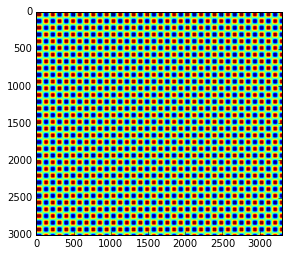

In [45]:
plt.imshow(out)
plt.show()